In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np


import wrangle as w
import evaluate as e
import model as m

import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression


from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score

from sklearn.feature_selection import f_regression 
from math import sqrt

#sklearn imports
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.feature_selection import RFE, SelectKBest, f_regression
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score


import wrangle as w
import evaluate as e


In [2]:
# retrieve the data from database or directory 
df = w.get_data()

In [3]:
# clean data, remove nulls, outliers and rename columns
df = w.clean_zillow()

378 outliers removed from area_sqft.
67 outliers removed from bathrooms.
85 outliers removed from bedroom.
0 outliers removed from pool.
0 outliers removed from year.
477 outliers removed from property_value.
0 outliers removed from full_bath.

Total of 1007 outliers removed.


In [4]:
# split the data into train, validate, test
train, validate, test = w.split_data(df)

In [5]:
# split the train, validate, test into x and y 
target = "property_value"
x_train, x_validate, x_test  = train[['area_sqft', 'bathrooms', 'bedroom', 'pool', 'year', 'full_bath','orange', 'ventura']], validate[['area_sqft', 'bathrooms', 'bedroom', 'pool', 'year', 'full_bath','orange', 'ventura']], test[['area_sqft', 'bathrooms', 'bedroom', 'pool', 'year', 'full_bath','orange', 'ventura']]
y_train, y_validate, y_test = train[target], validate[target], test[target]

In [31]:
target = "property_value"
x_train1, x_validate1, x_test1  = train[['area_sqft', 'bathrooms', 'bedroom','orange', 'ventura']], validate[['area_sqft', 'bathrooms', 'bedroom','orange', 'ventura']], test[['area_sqft', 'bathrooms', 'bedroom','orange', 'ventura']]
y_train1, y_validate1, y_test1 = train[target], validate[target], test[target]

# scale data 

In [7]:
# scale the x 
x_train_scaled, x_validate_scaled, x_test_scaled = w.mm_scale(x_train, x_validate, x_test)

In [32]:
x_train_scaled, x_validate_scaled, x_test_scaled = w.mm_scale(x_train1, x_validate1, x_test1)

In [33]:
x_train_scaled

,area_sqft,bathrooms,bedroom,orange,ventura
0,0.259907,0.333333,0.666667,1.0,0.0
1,0.177193,0.333333,0.500000,0.0,0.0
2,0.197093,0.333333,0.500000,0.0,0.0
3,0.133760,0.166667,0.166667,0.0,0.0
4,0.221838,0.333333,0.500000,0.0,0.0
...,...,...,...,...,...
30782,0.120782,0.166667,0.333333,1.0,0.0
30783,0.110573,0.166667,0.333333,0.0,0.0
30784,0.146219,0.166667,0.333333,0.0,0.0
30785,0.323239,0.500000,0.500000,0.0,0.0


In [34]:
# feature engineerin KBest 

In [35]:
m.select_kbest(x_train_scaled, y_train, 4)

Index(['area_sqft', 'bathrooms', 'bedroom', 'orange'], dtype='object')

In [36]:
# Rfe
m.rfe(x_train_scaled,y_train, k=4)

(['area_sqft', 'bathrooms', 'bedroom', 'orange'],
            rfe_ranking
 area_sqft            1
 bathrooms            1
 bedroom              1
 orange               1
 ventura              2)

In [37]:
def get_baseline(y_train):
    x_train_scaled["yhat_baseline"] = y_train.mean()
    return df

In [38]:
# create baseline
baseline = y_train.mean()
baseline

463588.2115178484

In [39]:
baseline_array = np.repeat(baseline, len(train))
baseline_array[:5]

array([463588.21151785, 463588.21151785, 463588.21151785, 463588.21151785,
       463588.21151785])

In [40]:
rmse, r2 = m.metrics_reg(y_train, baseline_array)
rmse, r2

(402475.23486790824, 0.0)

In [41]:
metrics_df = pd.DataFrame(data=[
    {
        'model':'baseline',
        'rmse':rmse,
        'r2':r2
    }
    
])
metrics_df

,model,rmse,r2
0,baseline,402475.234868,0.0


# OLS 

In [42]:
#intial ML model
lr1 = LinearRegression()

#make it
rfe = RFE(lr1, n_features_to_select=3)

#fit it
rfe.fit(x_train_scaled, y_train)

#use it on train
x_train_rfe1 = rfe.transform(x_train_scaled)

# #use it on validate
x_val_rfe1 = rfe.transform(x_validate_scaled)

In [43]:
#intial ML model
lr1 = LinearRegression()

#make it
rfe = RFE(lr1, n_features_to_select=3)

#fit it
rfe.fit(x_train_scaled, y_train)

#use it on train
x_train_rfe = rfe.transform(x_train_scaled)

# #use it on validate
x_val_rfe = rfe.transform(x_validate_scaled)

In [44]:
print('selected top feature:', rfe.get_feature_names_out())

selected top feature: ['area_sqft' 'bathrooms' 'bedroom']


In [45]:
#fit the thing
lr1.fit(x_train_rfe, y_train)

#use the thing (make predictions)
pred_lr1 = lr1.predict(x_train_rfe)
pred_val_lr1 = lr1.predict(x_val_rfe)

In [46]:
#train
m.metrics_reg(y_train, pred_lr1)


(322401.7752597692, 0.3583229244105084)

In [47]:
#validate
rmse, r2 = m.metrics_reg(y_validate, pred_val_lr1)
rmse, r2

(321099.0369977036, 0.35827413738719693)

In [48]:
#add to my metrics df
metrics_df.loc[1] = ['ols_1', rmse, r2]
metrics_df

,model,rmse,r2
0,baseline,402475.234868,0.000000
1,ols_1,321099.036998,0.358274


In [49]:
lr1.intercept_

115671.62208756089

In [50]:
lr1.coef_

array([1606220.77728373,  397086.38978055, -503335.77135026])

In [51]:
print(f'property value = {lr1.intercept_:.3} + {lr1.coef_[0]:.2}*bathroom')

property value = 1.16e+05 + 1.6e+06*bathroom


In [52]:
#make it
lr2 = LinearRegression()

#fit it on our RFE features
lr2.fit(x_train_scaled, y_train)

#use it (make predictions)
pred_lr2 = lr2.predict(x_train_scaled)

#use it on validate
pred_val_lr2 = lr2.predict(x_validate_scaled)

In [53]:
m.metrics_reg(y_train, pred_lr2)

(321894.68363629555, 0.36033986848372435)

In [54]:
# validate
rmse, r2 = m.metrics_reg(y_validate, pred_val_lr2)
rmse, r2

(320695.18000719725, 0.3598873623752652)

In [55]:
metrics_df.loc[2] = ['ols', rmse, r2]
metrics_df

,model,rmse,r2
0,baseline,402475.234868,0.000000
1,ols_1,321099.036998,0.358274
2,ols,320695.180007,0.359887


# Model LassoLars

In [56]:
#make it
lars = LassoLars(alpha=1)

#fit it
lars.fit(x_train_scaled, y_train)

#use it
pred_lars = lars.predict(x_train_scaled)
pred_val_lars = lars.predict(x_validate_scaled)

In [57]:
pd.Series(lars.coef_, index=lars.feature_names_in_)

area_sqft    1.595651e+06
bathrooms    3.885357e+05
bedroom     -5.030905e+05
orange       3.981861e+04
ventura     -7.100238e+03
dtype: float64

In [58]:
lr2.coef_

array([1597596.81224368,  390217.90933227, -506522.75461095,
         40122.31595613,   -7609.86282652])

In [59]:
#train
m.metrics_reg(y_train, pred_lars)

(321895.04545999254, 0.3603384304710112)

In [60]:
#validate
rmse, r2 = m.metrics_reg(y_validate, pred_val_lars)
rmse, r2

(320697.9796831018, 0.35987618593195025)

In [61]:
#add to my metrics df
metrics_df.loc[3] = ['lars', rmse, r2]
metrics_df

,model,rmse,r2
0,baseline,402475.234868,0.000000
1,ols_1,321099.036998,0.358274
2,ols,320695.180007,0.359887
3,lars,320697.979683,0.359876


In [64]:
x_test_scaled

,area_sqft,bathrooms,bedroom,orange,ventura
0,0.311992,0.333333,0.666667,1.0,0.0
1,0.265444,0.416667,0.666667,0.0,1.0
2,0.282056,0.500000,0.500000,0.0,0.0
3,0.296418,0.333333,0.500000,0.0,0.0
4,0.215954,0.333333,0.500000,1.0,0.0
...,...,...,...,...,...
10258,0.191729,0.333333,0.666667,0.0,0.0
10259,0.417373,0.583333,0.666667,1.0,0.0
10260,0.631597,0.583333,0.666667,0.0,1.0
10261,0.173559,0.333333,0.500000,0.0,0.0


# Poly

In [86]:
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=3)

# fit and transform X_train_scaled
x_train_degree2 = pf.fit_transform(x_train_scaled)

# transform X_validate_scaled & X_test_scaled
x_validate_degree2 = pf.transform(x_validate_scaled)
x_test_degree2 = pf.transform(x_test_scaled)

In [87]:
#make it
pr = LinearRegression()

#fit it
pr.fit(x_train_degree2, y_train)

#use it
pred_pr = pr.predict(x_train_degree2)
pred_val_pr = pr.predict(x_validate_degree2)


In [88]:
#train
m.metrics_reg(y_train, pred_pr)

(317852.4034464837, 0.3763044083381043)

In [89]:
#validate
rmse, r2 = m.metrics_reg(y_validate, pred_val_pr)
rmse, r2

(317007.86652578117, 0.3745226104816435)

In [90]:
#add to my metrics df
metrics_df.loc[4] = ['poly_2', rmse, r2]
metrics_df

,model,rmse,r2
0,baseline,402475.234868,0.000000
1,ols_1,321099.036998,0.358274
2,ols,320695.180007,0.359887
3,lars,320697.979683,0.359876
4,poly_2,317007.866526,0.374523
5,glm,320695.180003,0.359887
6,test,320535.477026,0.378483


# GLM

In [91]:
#make it
glm = TweedieRegressor(power=0, alpha=0)

#fit it
glm.fit(x_train_scaled, y_train)

#use it
pred_glm = glm.predict(x_train_scaled)
pred_val_glm = glm.predict(x_validate_scaled)

In [92]:
#train
m.metrics_reg(y_train, pred_glm)

(321894.6836362961, 0.36033986848372235)

In [93]:
#validate
rmse, r2 = m.metrics_reg(y_validate, pred_val_glm)
rmse, r2

(320695.18000321294, 0.3598873623911707)

In [94]:
metrics_df.loc[5] = ['glm',rmse,r2]
metrics_df

,model,rmse,r2
0,baseline,402475.234868,0.000000
1,ols_1,321099.036998,0.358274
2,ols,320695.180007,0.359887
3,lars,320697.979683,0.359876
4,poly_2,317007.866526,0.374523
5,glm,320695.180003,0.359887
6,test,320535.477026,0.378483


# Evaluate on best model

In [95]:
#use it
pred_test = pr.predict(x_test_degree2)
pred_test

array([ 414977.88692737,  356229.62742037,  490845.99148579, ...,
       1028195.69160272,  257373.1415021 ,  277482.77614726])

In [96]:
rmse, r2 = m.metrics_reg(y_test, pred_test)
rmse, r2 

(319736.07710546907, 0.3815795110484671)

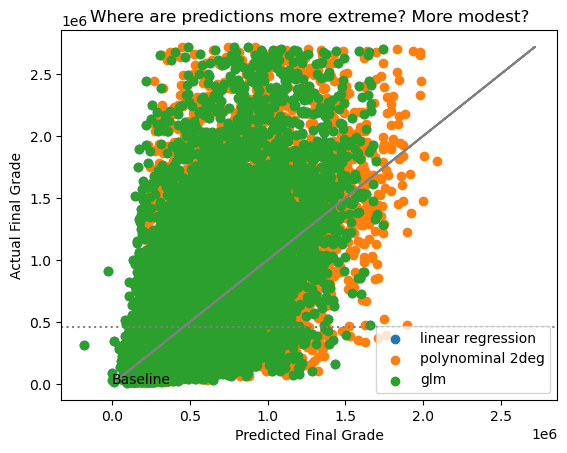

In [97]:
plt.scatter(pred_lr2, y_train, label='linear regression')
plt.scatter(pred_pr, y_train, label='polynominal 2deg')
plt.scatter(pred_glm, y_train, label='glm')
plt.plot(y_train, y_train, label='_nolegend_', color='grey')

plt.axhline(baseline, ls=':', color='grey')
plt.annotate("Baseline", (65, 81))

plt.title("Where are predictions more extreme? More modest?")
plt.ylabel("Actual Final Grade")
plt.xlabel("Predicted Final Grade")
plt.legend()

plt.show()

In [98]:
metrics_df.loc[6] = ['test',rmse,r2]
metrics_df

,model,rmse,r2
0,baseline,402475.234868,0.000000
1,ols_1,321099.036998,0.358274
2,ols,320695.180007,0.359887
3,lars,320697.979683,0.359876
4,poly_2,317007.866526,0.374523
5,glm,320695.180003,0.359887
6,test,319736.077105,0.381580


In [99]:
df.shape

(51313, 10)

<AxesSubplot:>

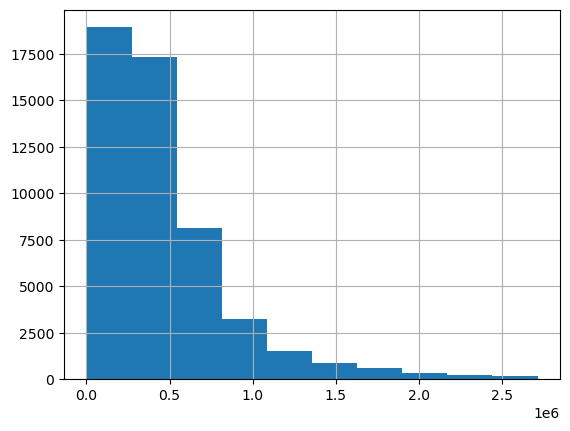

In [100]:
df.property_value.hist()